# Lab 7
## Machine Learning

### Importing Packages

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
from numpy.typing import ArrayLike
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor

seed = 42

# Ames Housing Dataset

The Ames Housing Dataset is a widely used dataset for regression modeling, particularly in real estate price prediction. It contains over 2,900 home sales from Ames, Iowa in the period of 2006–2010. It also includes 79 explanatory variables describing house features such as lot size, year built and quality measures.

This dataset is used in a  classic Kaggle data challenge, so if you get particularly good predictions you can sign up and submit them here:
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques.

In [82]:
# Load dataset
df = pd.read_csv("AmesHousing.csv")

To start we are only going to look at one of the most important predictors in the dataset, the Living Area of the house, and see how well we can use it to predict Sale Price.

In [83]:
# Select relevant columns
features = ["GrLivArea"]  # Living area
target = "SalePrice"
df_simplified = df[features + [target]].dropna()

# Log-transform the target to reduce the skewness
df_simplified[target] = np.log(df_simplified[target])

# Remove outliers as they can be quite troublesome in this dataset
df_simplified = df_simplified[df_simplified["GrLivArea"] < 4000]

# Split data into train and test with an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(df_simplified[features], df_simplified[target], test_size=0.2, random_state=42)

First thing we want to do is to plot the data.

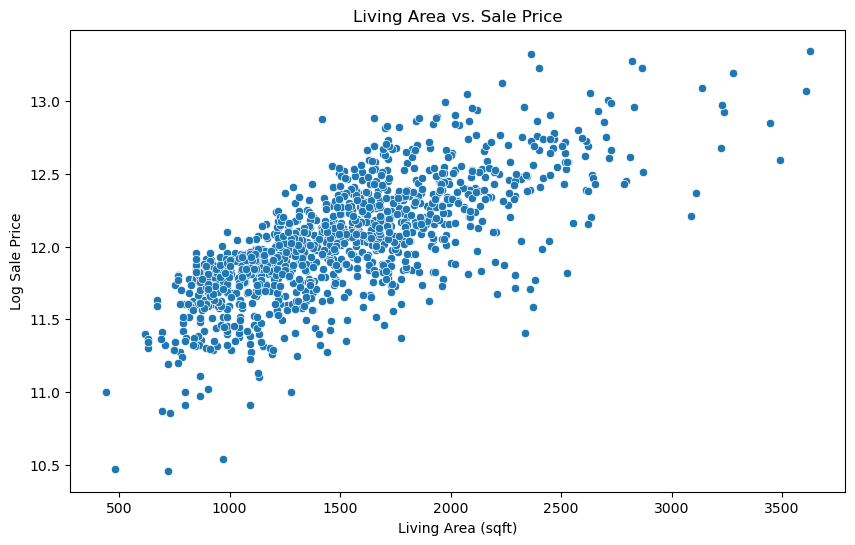

In [84]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train["GrLivArea"], y=y_train)
plt.xlabel("Living Area (sqft)")
plt.ylabel("Log Sale Price")
plt.title("Living Area vs. Sale Price")
plt.show()

Now we will calulate the theoretical confidence and prediction intervals for the linear regression model using the formulae we derived in the lecture. I have left some parts for you to fill in.

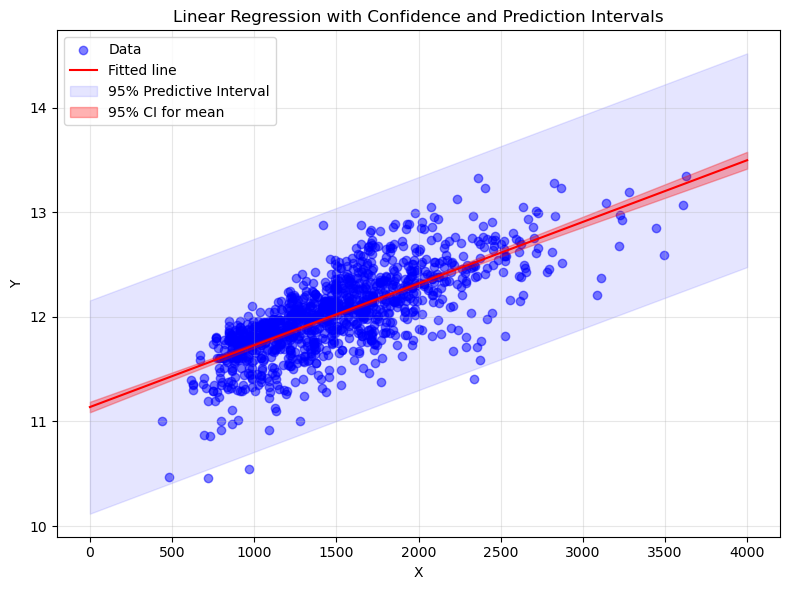

In [85]:
# Linear model
linear_model = LinearRegression().fit(X_train, y_train)

# Theoretical variance of the estimator
theta_hat = np.array([linear_model.intercept_, linear_model.coef_[0]])
y_pred = linear_model.predict(X_train)
sigma_hat = np.sqrt(np.mean((y_train - y_pred) ** 2))
X = np.column_stack((np.ones(len(X_train)), X_train))
theta_covar_matrix = sigma_hat ** 2 * np.linalg.inv(X.T @ X)

# Create prediction grid
x_pred = np.linspace(0, 4000, 100)
X_pred = np.column_stack((np.ones(len(x_pred)), x_pred))

# Compute prediction mean and standard error
y_pred_mean = X_pred @ theta_hat
pred_var = np.diag(X_pred @ theta_covar_matrix @ X_pred.T)
pred_std = np.sqrt(pred_var + sigma_hat)

# Plot the results
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
# Plot data points
axs.scatter(X[:, 1], y_train, color="blue", alpha=0.5, label="Data")
# Plot regression line
axs.plot(x_pred, y_pred_mean, "r-", label="Fitted line")
# Plot prediction intervals
axs.fill_between(
    x_pred,
    y_pred_mean - 1.96 * pred_std,
    y_pred_mean + 1.96 * pred_std,
    color="blue",
    alpha=0.1,
    label="95% Predictive Interval",
)
# Plot confidence intervals
axs.fill_between(
    x_pred,
    y_pred_mean - 1.96 * np.sqrt(pred_var),
    y_pred_mean + 1.96 * np.sqrt(pred_var),
    color="red",
    alpha=0.3,
    label="95% CI for mean",
)
axs.set_xlabel("X")
axs.set_ylabel("Y")
axs.set_title("Linear Regression with Confidence and Prediction Intervals")
axs.legend()
axs.grid(True, alpha=0.3)
fig.tight_layout()

## Bootstrap
Now we will compute the bootstrap confidence intervals for the coefficients, this is done by resampling the data with replacement and fitting the model again. This means we don't have to assume the normality of the coefficients but can still get an estimate of the uncertainty. The code for this is in the slides, see if you can extend the code from the slides to also make predictions across a range of reasonable values for GrLivArea.

Hint: A useful line of code for this is `X_pred = pd.DataFrame({"GrLivArea": np.linspace(0, 4000, 100)})` which defines a linear space over the range of GrLivArea, which we can then input into the model the same as we would new test values.

In [86]:
# Bootstrap
n_bootstrap = 10_000
bootstrap_predictions = []
bootstrap_coefs = []
X_pred = pd.DataFrame({"GrLivArea": np.linspace(0, 4000, 100)})

for _ in range(n_bootstrap):
    indices = np.random.choice(X_train.index, size=len(X_train), replace=True)
    # Sample with replacement
    X_boot = X_train.loc[indices]
    y_boot = y_train.loc[indices]

    # Compute bootstrap estimates
    linear_model = LinearRegression().fit(X_boot, y_boot)
    beta_boot = linear_model.coef_
    bootstrap_coefs.append(beta_boot)
    bootstrap_predictions.append(linear_model.predict(X_pred))

Now we plot the Bootstap and theoretical intervals in two different ways. In what ways do they differ? What does this tell us about our data?

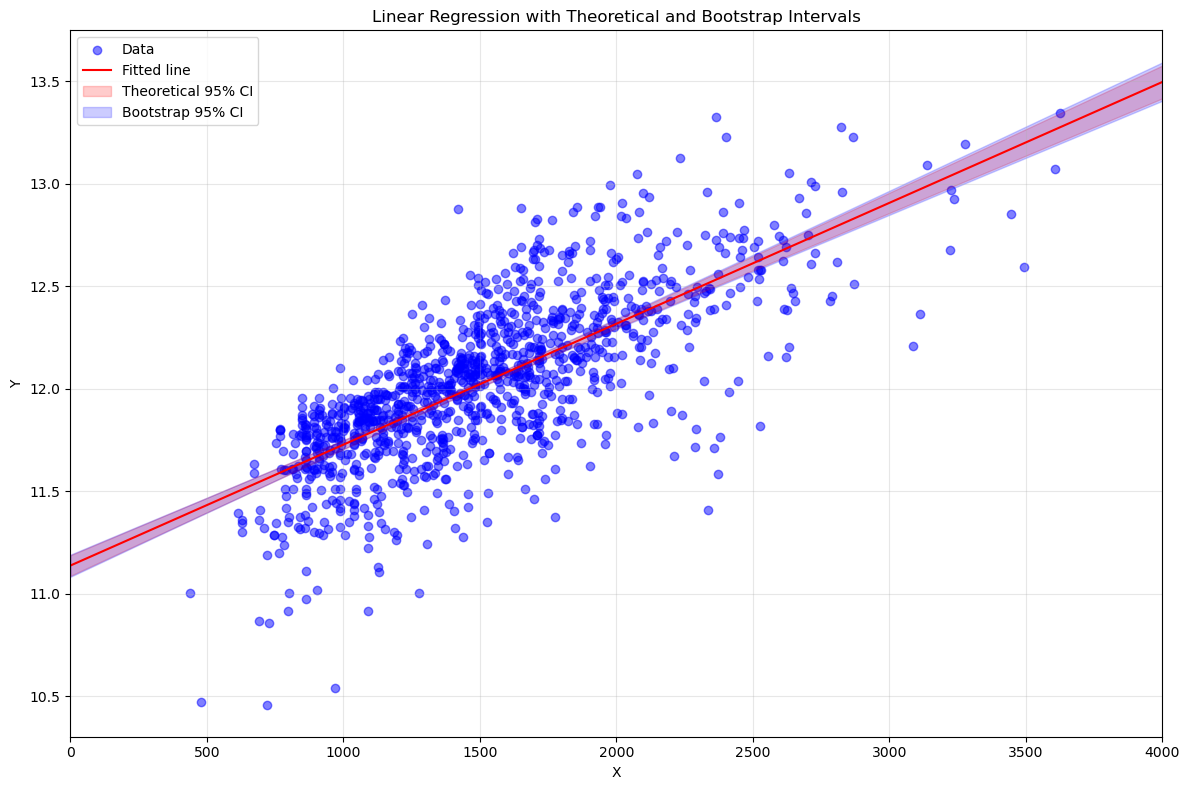

In [87]:
bootstrap_coefs = np.array(bootstrap_coefs)
bootstrap_predictions = np.array(bootstrap_predictions)

# Compute bootstrap intervals
pred_intervals = np.percentile(bootstrap_predictions, [2.5, 97.5], axis=0)

# Plot bootstrap
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
# Plot data points
axs.scatter(X[:, 1], y_train, color="blue", alpha=0.5, label="Data")
# Plot regression line
axs.plot(x_pred, y_pred_mean, "r-", label="Fitted line")
# Plot theoretical confidence intervals
axs.fill_between(
    x_pred,
    y_pred_mean - 1.96 * np.sqrt(pred_var),
    y_pred_mean + 1.96 * np.sqrt(pred_var),
    color="red",
    alpha=0.2,
    label="Theoretical 95% CI",
)
axs.fill_between(
    x_pred,
    pred_intervals[0],
    pred_intervals[1],
    color="blue",
    alpha=0.2,
    label="Bootstrap 95% CI",
)
axs.set_xlabel("X")
axs.set_ylabel("Y")
axs.set_title("Linear Regression with Theoretical and Bootstrap Intervals")
axs.legend()
axs.grid(True, alpha=0.3)
axs.set_xlim([0, 4000])
fig.tight_layout()
plt.show()

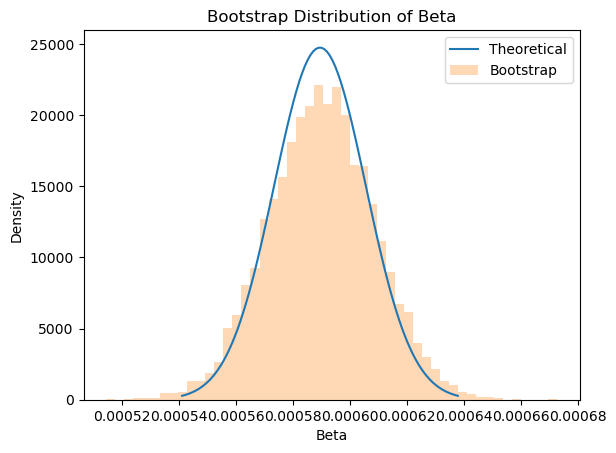

In [88]:
beta_std = np.sqrt(theta_covar_matrix[1, 1])
beta_hat = theta_hat[1]
beta_range = np.linspace(beta_hat - 3 * beta_std, beta_hat + 3 * beta_std, 100)
beta_dist = scipy.stats.norm.pdf(beta_range, beta_hat, beta_std)
plt.plot(beta_range, beta_dist, label="Theoretical")
plt.hist(bootstrap_coefs, density=True, alpha=0.3, label="Bootstrap", bins=50)
plt.xlabel("Beta")
plt.ylabel("Density")
plt.title("Bootstrap Distribution of Beta")
plt.legend()
plt.show()

## Quantile Regression

Now we will implement the quantile regression on the same data to get a better sense of the variability. For the moment we will use scikit-learn for the implementation, but if you want an even more flexible implementation you can see the example code from Chris on moodle which uses jax instead.

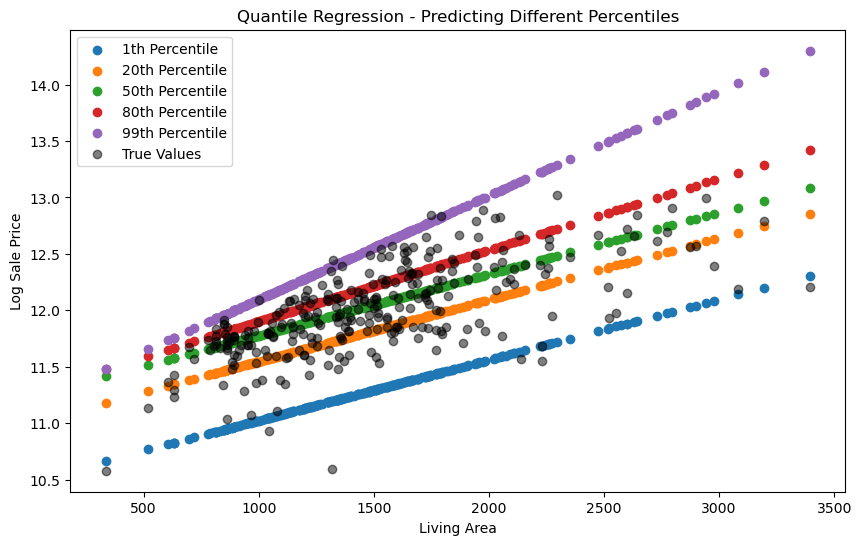

In [89]:
quantiles = [0.01, 0.2, 0.5, 0.8, 0.99]
q_models = {q: QuantileRegressor(quantile=q, alpha=0) for q in quantiles}
q_models_coefs = []

plt.figure(figsize=(10, 6))
for q, model in q_models.items():
    model.fit(X_train["GrLivArea"].values.reshape(-1, 1), y_train)
    y_pred = model.predict(X_test["GrLivArea"].values.reshape(-1, 1))
    plt.scatter(X_test["GrLivArea"], y_pred, label=f"{int(q * 100)}th Percentile")
plt.scatter(X_test["GrLivArea"], y_test, color="black", alpha=0.5, label="True Values") 
plt.xlabel("Living Area")
plt.ylabel("Log Sale Price")
plt.legend()
plt.title("Quantile Regression - Predicting Different Percentiles")
plt.show()

In [90]:
q_coefs = []

for q in quantiles:
    coef = q_models[q].coef_
    q_coefs.append(coef)

q_coefs

[array([0.000536]),
 array([0.00054726]),
 array([0.00054455]),
 array([0.00063262]),
 array([0.00091982])]

In [91]:
y_pred_99 = q_models[0.99].predict(X_train[["GrLivArea"]])
residuals_99 = y_train - y_pred_99


tolerance = 1e-1
support_idx_99 = np.where(np.abs(residuals_99) < tolerance)[0]

# Subset your data
X_support_99 = X_train.iloc[support_idx_99]
y_support_99 = y_train.iloc[support_idx_99]




C:\Users\felix\miniconda3\envs\ml2025\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but QuantileRegressor was fitted without feature names
  warnings.warn(


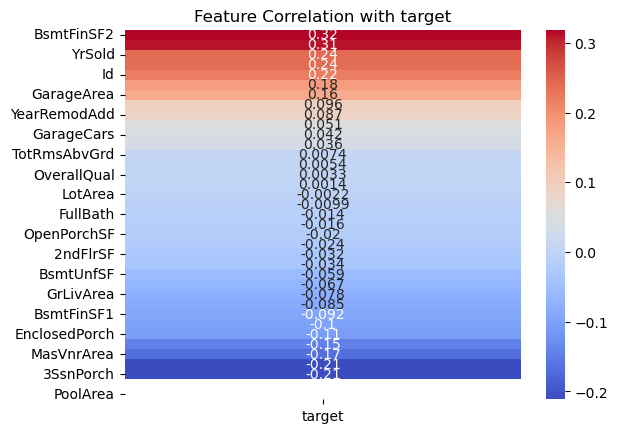

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr_array_with_series(X, y, feature_names=None, target_name="target"):
    """
    Plots correlation of each column in X (np.array) with the target Series y.
    """
    if feature_names is None:
        feature_names = [f"X{i}" for i in range(X.shape[1])]
    
    # Build a temporary DataFrame
    df = pd.DataFrame(X, columns=feature_names)
    df[target_name] = y.values

    # Compute correlation
    corr = df.corr(numeric_only=True)[[target_name]].drop(target_name)

    # Plot
    sns.heatmap(corr.sort_values(by=target_name, ascending=False), annot=True, cmap="coolwarm")
    plt.title(f"Feature Correlation with {target_name}")
    plt.show()

# Load the dataset again for clarity
X_corr = pd.read_csv("AmesHousing.csv")
numerical_features = X_corr.select_dtypes(include=['float64', 'int64']).columns
categorical_features = df.select_dtypes(include=['object', 'category']).columns
numerical_features = numerical_features.drop("SalePrice")
X_corr = X_corr[X_corr["GrLivArea"] < 4000]
X_corr = X_corr.drop(columns=categorical_features)
X_Corr, _, _, _ = train_test_split(X_corr, X_Corr, test_size=0.2, random_state=42)

plot_corr_array_with_series(X_corr.iloc[support_idx_99], y_support_99, feature_names=numerical_features)


There seems to be no good numerical proxy...

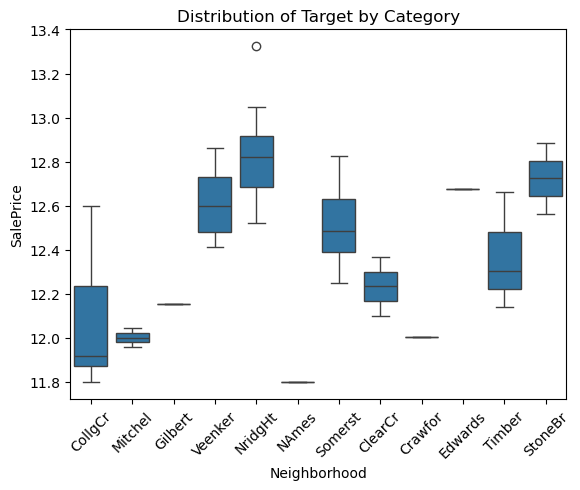

In [107]:
X_cat = pd.read_csv("AmesHousing.csv")
X_cat = X_cat[X_cat["GrLivArea"] < 4000]
X_cat = X_cat.drop(columns=numerical_features)
X_cat, _, _, _ = train_test_split(X_cat, X_cat, test_size=0.2, random_state=42)
X_cat_99 = X_cat.iloc[support_idx_99]

sns.boxplot(x=X_cat_99["Neighborhood"], y=y_support_99)
plt.xticks(rotation=45)
plt.title("Distribution of Target by Category")
plt.show()

### Quantile Regression for Tree-Based Models

Now we want to fit a fully flexible Tree-based quantile model to the data. To do so we need to do quite a few preprocessing steps. Make sure everything here makes sense to you. This is only one potential way to clean this data. When you get to the final step feel free to change any of these choices to try improve the model.

In [47]:
# Load the dataset again for clarity
df = pd.read_csv("AmesHousing.csv")

#Some columns have a lot of missing values, so we will drop them
cols_to_drop = ['FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'Alley', 'MasVnrType']
df = df.drop(columns=cols_to_drop)

# log transform the target
target = "SalePrice"
df[target] = np.log(df[target])

# Remove outliers
df = df[df["GrLivArea"] < 4000] 

categorical_features = df.select_dtypes(include=['object', 'category']).columns
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
numerical_features = numerical_features.drop(target)

#Train-test split
X_train_full, X_test_full, y_train, y_test = train_test_split(df.drop(columns=[target]), df[target], test_size=0.2, random_state=42)

# Preprocess the data by one-hot encoding the categorical features and imputing the missing values in the numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output= False), categorical_features),
        ('num', SimpleImputer(strategy='mean'), numerical_features)
    ],
    remainder='passthrough'
)

X_train_full = preprocessor.fit_transform(X_train_full)
X_test_full = preprocessor.transform(X_test_full)

### Fitting the Model

Now we fit the model with the same quantiles as before and a set of parameters I chose fairly arbitrarily. See if you can fill the fitting process in from the code in the lecture slides.

Hint: I would add `verbosity=-1` to any LightBGM model I run to prevent loads of warnings.

In [48]:
quantile_alphas = [0.1, 0.5, 0.9]

lgb_params = {
    'n_jobs': 1,
    'max_depth': 4,
    'min_data_in_leaf': 10,
    'subsample': 0.9,
    'n_estimators': 100,
    'learning_rate': 0.1,
    'colsample_bytree': 0.9
}

lgb_quantile_alphas = {}
for quantile_alpha in quantile_alphas:
    lgb = LGBMRegressor(objective='quantile', alpha=quantile_alpha, **lgb_params, verbosity=-1)
    lgb.fit(X_train_full, y_train)
    lgb_quantile_alphas[quantile_alpha] = lgb

Now lets compute the prediction for the different bounds of the test data. I have provided the code for this as it is a good example of looping over models themselves, make sure you understand it.

In [49]:
quantile_predictions = {}
for quantile_alpha, model in lgb_quantile_alphas.items():
    quantile_predictions[quantile_alpha] = model.predict(X_test_full)

C:\Users\felix\miniconda3\envs\ml2025\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\felix\miniconda3\envs\ml2025\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\felix\miniconda3\envs\ml2025\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Let's plot the predictions and analyse to see how well we think our model is doing.

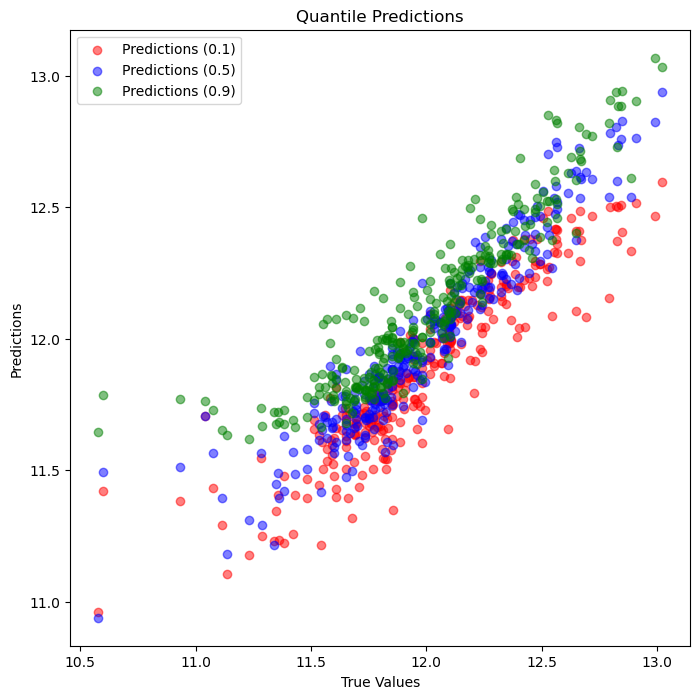

In [50]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, quantile_predictions[0.1], color='red', alpha=0.5, label='Predictions (0.1)')
plt.scatter(y_test, quantile_predictions[0.5], color='blue', alpha=0.5, label='Predictions (0.5)')
plt.scatter(y_test, quantile_predictions[0.9], color='green', alpha=0.5, label='Predictions (0.9)')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Quantile Predictions")
plt.legend()
plt.show()

I also selected a smaller subset of the test data, show the predictions for the 0.1, 0.5, and 0.9 quantiles and the true values. 

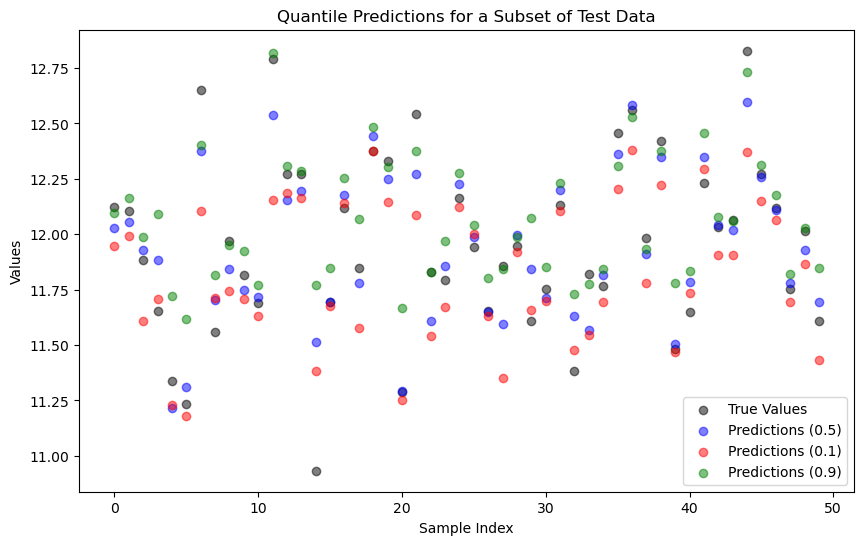

In [51]:
n_samples = 50
plt.figure(figsize=(10, 6))
plt.scatter(range(n_samples), y_test[:n_samples], color='black', alpha=0.5, label='True Values')
plt.scatter(range(n_samples), quantile_predictions[0.5][:n_samples], color='blue', alpha=0.5, label='Predictions (0.5)')
plt.scatter(range(n_samples), quantile_predictions[0.1][:n_samples], color='red', alpha=0.5, label='Predictions (0.1)')
plt.scatter(range(n_samples), quantile_predictions[0.9][:n_samples], color='green', alpha=0.5, label='Predictions (0.9)')
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.title("Quantile Predictions for a Subset of Test Data")
plt.legend()
plt.show()

## Pinball Loss / Quantile Loss
As we are no longer fitting a mean-based model, it does not make sense to evaluate models with the MSE, instead we use the quantile loss, which can also be called the Pinball Loss. The code below calculates the pinball loss for each of our quantiles.

For a given quantile $\tau$ and a prediction $\hat{y}$ for an actual value $y$, the pinball loss is calculated as:

$$
L_{\tau}(y, \hat{y}) =
\begin{cases}
\tau(y - \hat{y}) & \text{if } y \geq \hat{y} \quad (\text{underestimation penalty})\\
(1 - \tau)(\hat{y} - y) & \text{if } y < \hat{y} \quad (\text{overestimation penalty})
\end{cases}
$$

- If $y$ is **greater than** $\hat{y}$, the loss is proportional to **$\tau$** times the error.
- If $y$ is **less than** $\hat{y}$, the loss is proportional to **$(1 - \tau)$** times the error.
- This means **over-predicting is penalized less than under-predicting for high quantiles** (e.g., $\tau=0.9$) and vice versa for low quantiles ($\tau=0.1$).



In [52]:
pinball_losses = {}

for quantile_alpha in quantile_alphas:
    pinball_losses[quantile_alpha] = np.mean(np.maximum(quantile_predictions[quantile_alpha] - y_test, 0) * quantile_alpha + np.maximum(y_test - quantile_predictions[quantile_alpha], 0) * (1 - quantile_alpha))
    
pinball_losses

{0.1: np.float64(0.11691212282960793),
 0.5: np.float64(0.044914768104501346),
 0.9: np.float64(0.11775515877716339)}

Now lets see what proportion of the true values fall below the 0.1 and 0.9 quantile predictions? Do you think our model is doing well?

In [53]:
within_quantiles = np.mean((quantile_predictions[0.1] <= y_test) & (y_test <= quantile_predictions[0.9]))

print(f"Proportion of true values within the 0.1 and 0.9 quantile predictions: {within_quantiles:.2f}")

Proportion of true values within the 0.1 and 0.9 quantile predictions: 0.64


### Main Task:
Think about how you could further finetune this model and implement it. See if you can improve on the metrics above.